## 28. Titanic voting_78947

### 1. 사용 라이브러리

In [1]:
# 시각화 및 전처리
import csv
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 학습, 튜닝
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# 사용모델
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
# pip install lightgbm
# pip install xgboost

# 그 외
from IPython.display import Image 
import warnings 
warnings.filterwarnings('ignore')
# !pip install IPython 



#### train data 

In [2]:
import csv
train = pd.read_csv('train.csv')
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


#### test data

In [3]:
test = pd.read_csv('test.csv')
test.tail(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [4]:
# train 결측값
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# test 결측값
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### 2. 결측치 처리

2.1. Age -> 평균 29.69

왜도값 0.39로 데이터의 치우침이 크지 않은 범위( -2 ~ 2 ) 

Age 분포 왜도 : 0.39


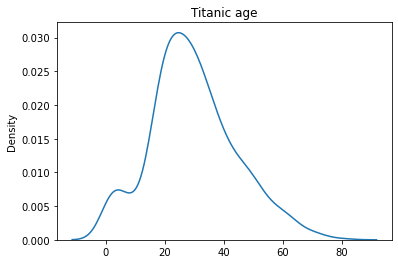

In [6]:
# Age 분포

sns.kdeplot(train['Age'].values)
plt.title('Titanic age')
print(f'Age 분포 왜도 : {(train["Age"].skew()).round(2)}')
plt.show()

In [7]:
train['Age'] = train['Age'].fillna(29.69) 
test['Age'] = test['Age'].fillna(29.69)

2.2 Embarked, Fare -> 최빈값

In [8]:
train['Embarked'] = train['Embarked'].fillna('S')
test['Fare'] = test['Fare'].fillna(8.05)

### 3. 비대칭 분포(Fare)에 Log

양의 방향으로 왜도값이 큰 비대칭 데이터(skew : 4.78)


In [9]:
print(train['Fare'].skew())

4.787316519674893


No handles with labels found to put in legend.


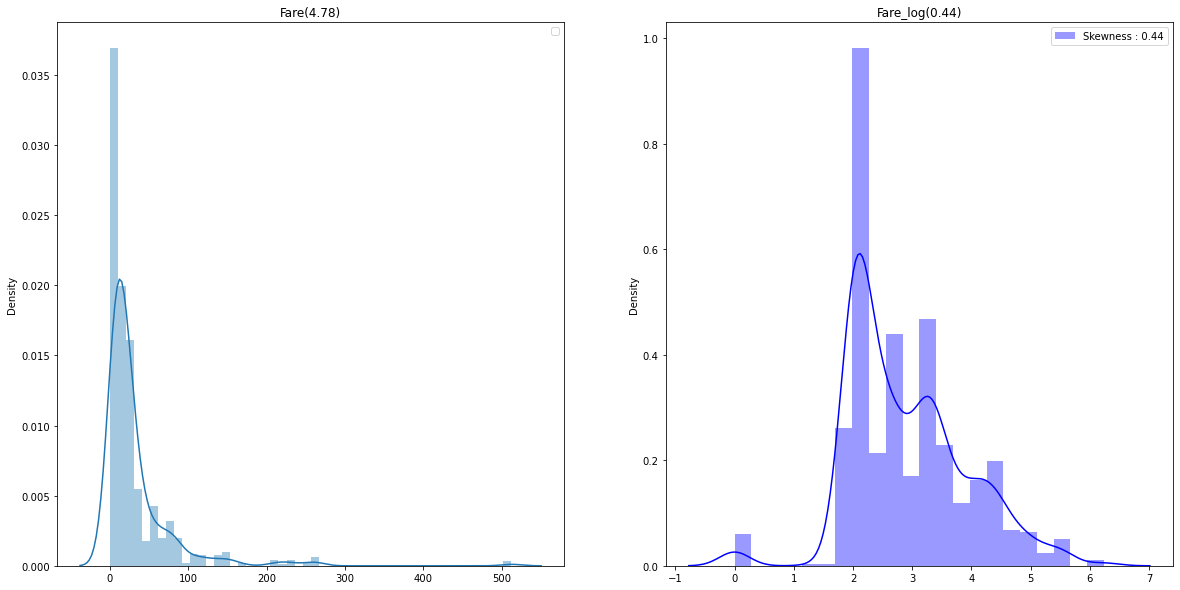

In [10]:
# log 전
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(20,10)
sns.distplot(train['Fare'].values, ax=ax1)

# log 
train['Fare'] = train['Fare'].apply(lambda x: np.log(x) if x > 0 else 0)
test['Fare'] = test['Fare'].apply(lambda x: np.log(x) if x > 0 else 0)

# log 후
sns.distplot(train['Fare'],color='b',label='Skewness : {:.2f}'.format(train['Fare'].skew()), ax=ax2)
ax1.set(xlabel='')
ax2.set(xlabel='')
ax1.set(title="Fare(4.78)")
ax2.set(title="Fare_log(0.44)")
ax1.legend(loc='best')
ax2.legend(loc='best')

### 4. 새 변수 생성

Age > Age_gr

In [11]:
def age_gr(x):
    if x < 5 :
       return 0
    if 5<=x<10:
       return 1
    if 10<=x<16:
       return 2
    if 16<=x<20:
       return 3    # 16세~ 성인 간주 
    if 20<=x<30:
       return 20
    if 30<=x<40:
       return 30
    if 40<=x<50:
       return 40
    if 50<=x<60:
       return 50
    if 60<=x<70:
       return 60
    if 70<=x<80:
       return 70
    if 80<=x<90:
       return 80


In [12]:
train['Age_gr'] = train['Age'].apply(lambda x:age_gr(x))
test['Age_gr'] = test['Age'].apply(lambda x:age_gr(x))

f_nm

In [13]:
train['F_nm'] = train['SibSp'] + train['Parch']
test['F_nm'] = test['SibSp'] + test['Parch']

f_ox

In [14]:
def f_ox(x):
    if x == 0:
        return 0
    if x >= 1:
        return 1   

In [15]:
train['F_ox'] = train['F_nm'].apply(lambda x: f_ox(x))
test['F_ox'] = test['F_nm'].apply(lambda x: f_ox(x))

Fare > Fare_gr

In [16]:
train['Fare'] = pd.qcut(train['Fare'], 5)
test['Fare'] = pd.qcut(test['Fare'], 5)

train['Fare'].value_counts()

(2.061, 2.351]     184
(3.076, 3.681]     180
(-0.001, 2.061]    179
(3.681, 6.239]     176
(2.351, 3.076]     172
Name: Fare, dtype: int64

In [17]:
train['Fare'] = train['Fare'].astype('category').cat.codes
test['Fare'] = test['Fare'].astype('category').cat.codes

Name > Married

In [18]:
train['Name'] = train['Name'].str.split(',').str[1]
train['Name'] = train['Name'].str.split('.').str[0]

In [19]:
test['Name'] = test['Name'].str.split(',').str[1]
test['Name'] = test['Name'].str.split('.').str[0]

In [20]:
my = [' Mr', ' Mrs']
mn = [' Miss', ' Master', ' Rev', ' Mlle']

train['Married'] = train['Name'].apply(lambda x : 0 if x in my else 1 if x in mn else 9)  
test['Married'] = test['Name'].apply(lambda x : 0 if x in my else 1 if x in mn else 9)      

### 5. Encoding 

- 원핫 : 이 데이터는 연속성이 없습니다.
- 라벨 : 이 데이터는 연속성을 가집니다. (그래서 커질수록 가중치를 부여합니다)

연속성이 보이지 않고 3 범주 이하의 변수 > 원핫 인코딩 

In [21]:
# sex, f_nm, Married 원핫 


s_oh = pd.get_dummies(train['Sex'], prefix='Sex')
s_oh2 = pd.get_dummies(test['Sex'], prefix='Sex')

f_oh = pd.get_dummies(train['F_ox'], prefix='F_ox')
f_oh2 = pd.get_dummies(test['F_ox'], prefix='F_ox')

m_oh = pd.get_dummies(train['Married'], prefix='Married')
m_oh2 = pd.get_dummies(test['Married'], prefix='Married')

df = [s_oh, f_oh, m_oh]
df2 = [s_oh2, f_oh2, m_oh2]

for i in df :
    train = pd.concat([train, i], axis=1)
for i in df2 :
    test = pd.concat([test, i], axis=1)    

target과의 관계에서 연속적인 증가/감소가 보이는 변수 > 레이블 인코딩

In [22]:
# pclass, fare, embarked 레이블 인코딩 
# fit_transform

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

train['Pclass'] = encoder.fit_transform(train['Pclass'])
test['Pclass'] = encoder.fit_transform(test['Pclass'])

train['Fare'] = encoder.fit_transform(train['Fare'])
test['Fare'] = encoder.fit_transform(test['Fare'])

train['Embarked'] = encoder.fit_transform(train['Embarked'])
test['Embarked'] = encoder.fit_transform(test['Embarked'])

In [23]:
def sex(x):
    if x == 'male':
        return 0
    else : 
        return 1
        
train['Sex'] = train['Sex'].apply(lambda x: sex(x))
test['Sex'] = test['Sex'].apply(lambda x: sex(x))

#### 곱사리. 시각화 

[Text(0.5, 1.0, 'Fare')]

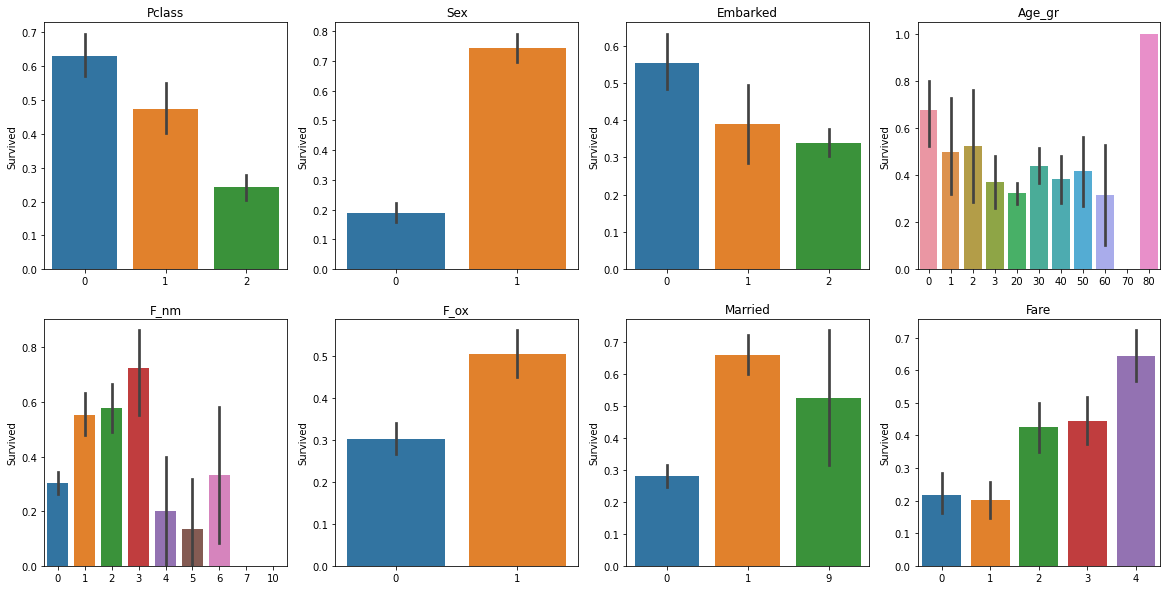

In [25]:
# 변수별 평균 생존률

fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4)
fig.set_size_inches(20,10)

sns.barplot(x='Pclass', y='Survived',data= train, ax=ax1)
sns.barplot(x='Sex', y='Survived',data= train, ax=ax2)
sns.barplot(x='Embarked', y='Survived',data= train, ax=ax3)
sns.barplot(x='Age_gr', y='Survived',data= train, ax=ax4)
sns.barplot(x='F_nm', y='Survived',data= train, ax=ax5)
sns.barplot(x='F_ox', y='Survived',data= train, ax=ax6)
sns.barplot(x='Married', y='Survived',data= train, ax=ax7)
sns.barplot(x='Fare', y='Survived', data= train, ax=ax8)

ax1.set(xlabel='')
ax2.set(xlabel='')
ax3.set(xlabel='')
ax4.set(xlabel='')
ax5.set(xlabel='')
ax6.set(xlabel='')
ax7.set(xlabel='')
ax8.set(xlabel='')

ax1.set(title="Pclass")
ax2.set(title="Sex")
ax3.set(title="Embarked")
ax4.set(title="Age_gr")
ax5.set(title="F_nm")
ax6.set(title="F_ox")
ax7.set(title="Married")
ax8.set(title='Fare')

,Survived
Pclass,
0,0.629630
1,0.472826
2,0.242363


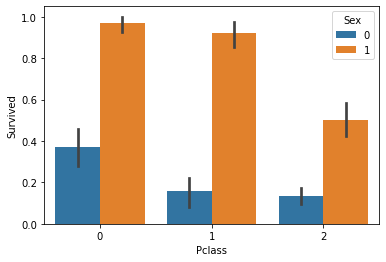

In [27]:
sns.barplot(data=train, x='Pclass', y='Survived', hue='Sex')

train[['Pclass','Survived']].groupby('Pclass').mean()

<AxesSubplot:xlabel='Fare', ylabel='Survived'>

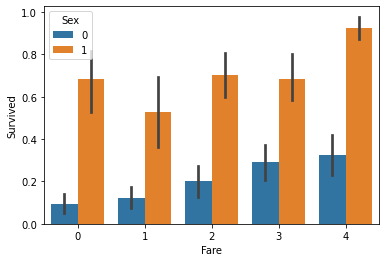

In [28]:
sns.barplot(data=train, x='Fare', y='Survived', hue='Sex')

train[['Pclass','Survived']].groupby('Pclass').mean()

#### 6. 필요없는 변수 drop

In [ ]:
train = train.drop(['PassengerId', 'Name','Age','SibSp','Cabin','Parch', 'Ticket','F_ox','Married'], axis=1)
test = test.drop(['Name','Age','SibSp','Cabin','Parch', 'Ticket','F_ox','Married'], axis=1)

In [ ]:
train.head()

,Survived,Pclass,Sex,Fare,Embarked,Age_gr,F_nm,Sex_female,Sex_male,F_ox_0,F_ox_1,Married_0,Married_1,Married_9
0,0,2,0,0,2,20,1,0,1,0,1,1,0,0
1,1,0,1,4,0,30,1,1,0,0,1,1,0,0
2,1,2,1,1,2,20,0,1,0,1,0,0,1,0
3,1,0,1,4,2,30,1,1,0,0,1,1,0,0
4,0,2,0,1,2,30,0,0,1,1,0,1,0,0


In [ ]:
test.head()

,PassengerId,Pclass,Sex,Fare,Embarked,Age_gr,F_nm,Sex_female,Sex_male,F_ox_0,F_ox_1,Married_0,Married_1,Married_9
0,892,2,0,1,1,30,0,0,1,1,0,1,0,0
1,893,2,1,0,2,40,1,1,0,0,1,1,0,0
2,894,1,0,1,1,60,0,0,1,1,0,1,0,0
3,895,2,0,1,2,20,0,0,1,1,0,1,0,0
4,896,2,1,2,2,20,2,1,0,0,1,1,0,0


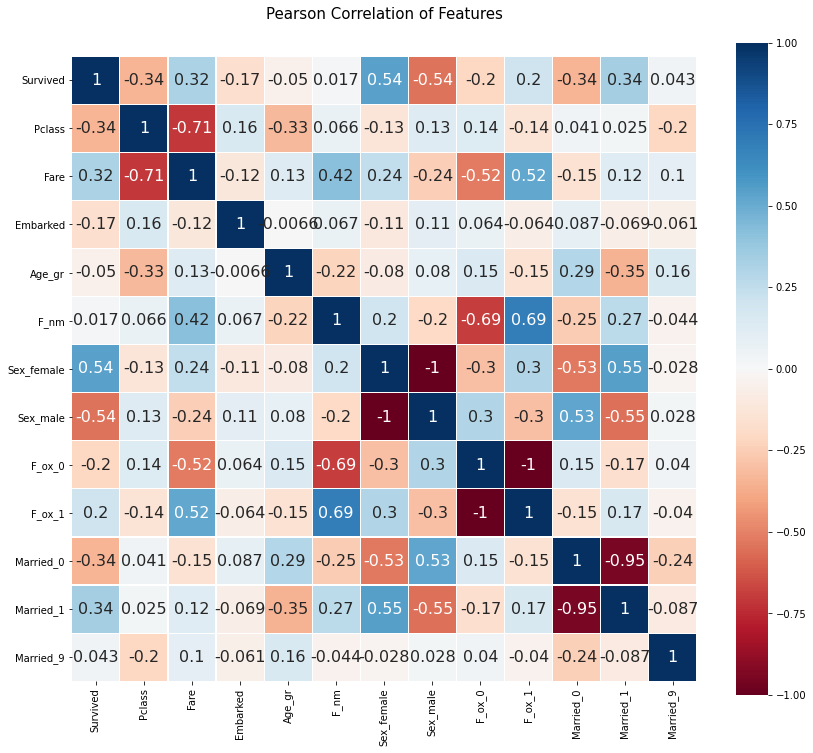

In [ ]:
heatmap_data = train[['Survived', 'Pclass', 'Fare', 'Embarked', 'Age_gr', 'F_nm',
       'Sex_female', 'Sex_male', 'F_ox_0', 'F_ox_1', 'Married_0', 'Married_1',
       'Married_9']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data

### 7. feature importance 

In [ ]:
dtree = DecisionTreeClassifier(random_state=2022)
rfc = RandomForestClassifier(random_state=2022)
xgb = XGBClassifier(random_state=2022, eval_metric='mlogloss')
lgbm = LGBMClassifier(random_state=2022)

In [ ]:
X = train.iloc[:,1:].values
y = train['Survived']
X_test = test.drop(['PassengerId'], axis=1)
X.shape, y.shape, X_test.shape

((891, 13), (891,), (418, 13))

In [ ]:
dtree.fit(X, y)
rfc.fit(X, y)
xgb.fit(X, y)
lgbm.fit(X, y)

LGBMClassifier(random_state=2022)

Text(0.5, 1.0, 'lgbm')

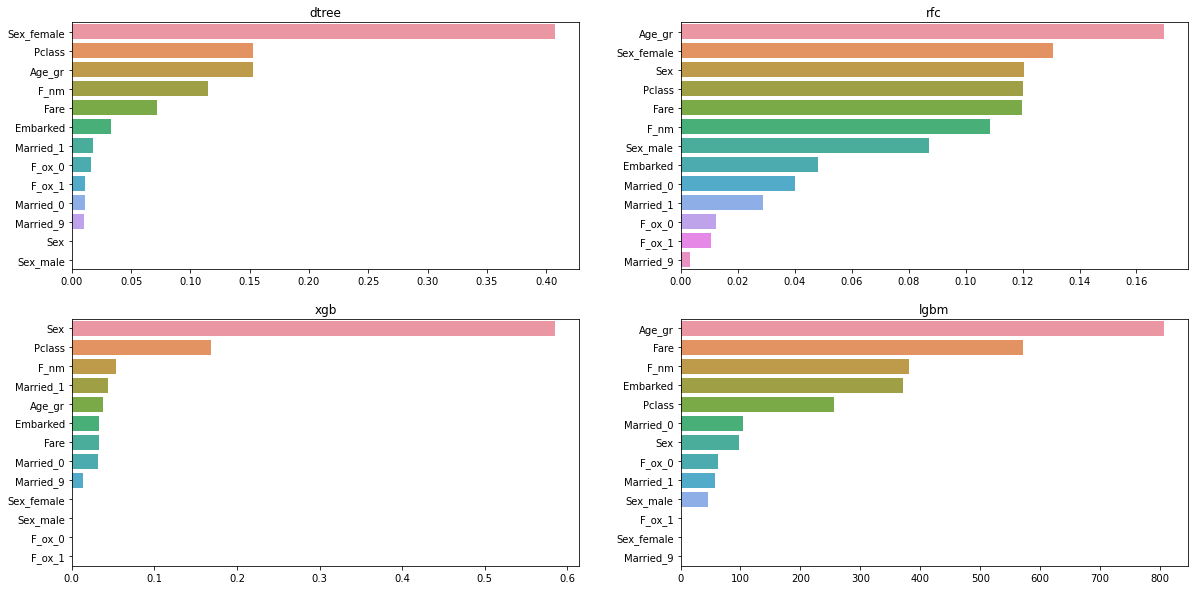

In [ ]:
fig, ((ax1,ax2),(ax3, ax4)) = plt.subplots(2,2)
fig.set_size_inches(20,10)


ft_importance_values1 = dtree.feature_importances_
ft_importance_values2 = rfc.feature_importances_
ft_importance_values3 = xgb.feature_importances_
ft_importance_values4 = lgbm.feature_importances_


ft_series = pd.Series(ft_importance_values1, index = train.iloc[:,1:].columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]
sns.barplot(x=ft_top20, y=ft_top20.index, ax=ax1)
ax1.set(title='dtree')

ft_series = pd.Series(ft_importance_values2, index = train.iloc[:,1:].columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]
sns.barplot(x=ft_top20, y=ft_top20.index, ax=ax2)
ax2.set(title='rfc')

ft_series = pd.Series(ft_importance_values3, index = train.iloc[:,1:].columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]
sns.barplot(x=ft_top20, y=ft_top20.index, ax=ax3)
ax3.set(title='xgb')

ft_series = pd.Series(ft_importance_values4, index = train.iloc[:,1:].columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]
sns.barplot(x=ft_top20, y=ft_top20.index, ax=ax4)
plt.title('lgbm')

**Age_gr, male, female, pclass, f_nm, fare**  


### 8. 변수 중요도로부터 새 변수 생성

- F_nm
- 0~3명까지, 여성의 생존률은 매우 높음

<AxesSubplot:xlabel='F_nm', ylabel='Survived'>

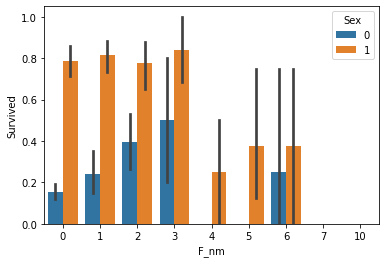

In [ ]:
sns.barplot(x='F_nm', y='Survived', hue='Sex', data= train)

In [ ]:
def under_3(x):
    if x<=3:
        return 1 
    else : 
        return 0   

def f_under_3(x):
    if x ==2:
        return 1
    else:
        return 0

In [ ]:
train['under_3'] = train['F_nm'].apply(lambda x : under_3(x))  
test['under_3'] = test['F_nm'].apply(lambda x : under_3(x)) 

train['f_under_3'] = train['Sex_female'] + train['under_3']
test['f_under_3'] = test['Sex_female'] + test['under_3']

train['f_under_3'] = train['f_under_3'].apply(lambda x : f_under_3(x))  
test['f_under_3'] = test['f_under_3'].apply(lambda x : f_under_3(x))   

In [ ]:
train = train.drop(['under_3','Sex' ], axis=1)
test = test.drop(['under_3', 'Sex' ], axis=1)

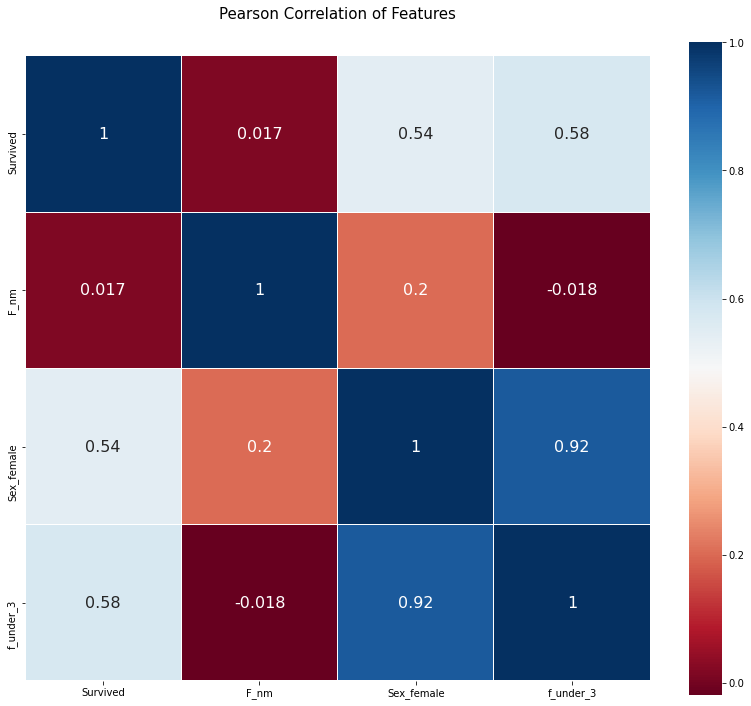

In [ ]:
heatmap_data = train[['Survived', 'F_nm','Sex_female', 'f_under_3']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data

In [ ]:
X = train.iloc[:,1:].values
y = train['Survived']
X_test = test.drop(['PassengerId'], axis=1)
X.shape, y.shape, X_test.shape

dtree.fit(X, y)
rfc.fit(X, y)
xgb.fit(X, y)
lgbm.fit(X, y)

LGBMClassifier(random_state=2022)

Text(0.5, 1.0, 'lgbm')

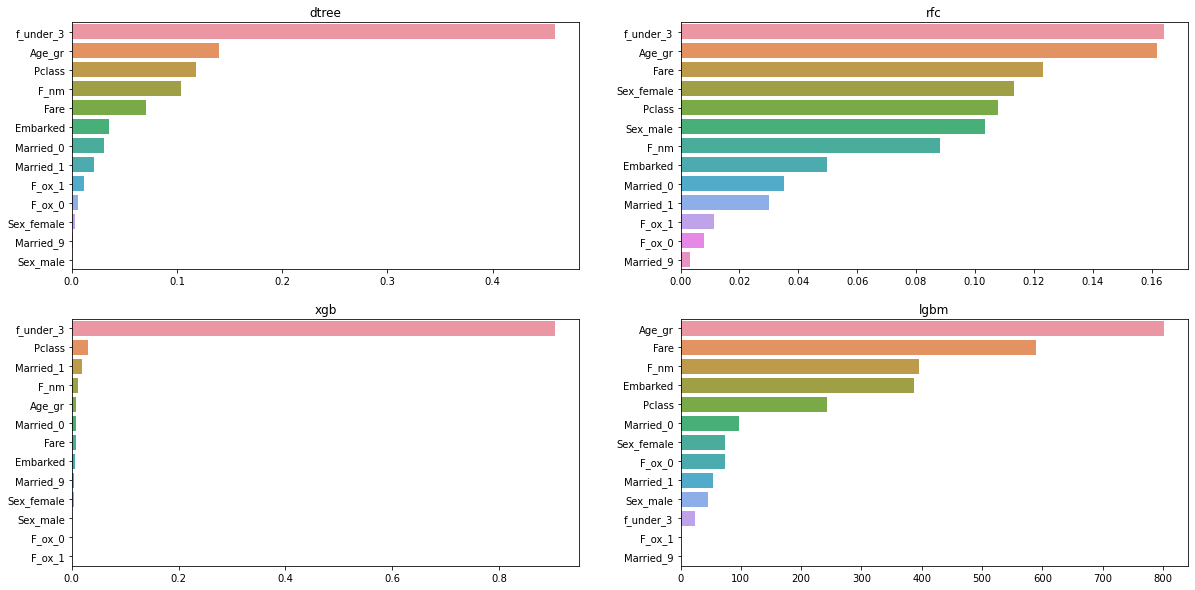

In [ ]:
fig, ((ax1,ax2),(ax3, ax4)) = plt.subplots(2,2)
fig.set_size_inches(20,10)


ft_importance_values1 = dtree.feature_importances_
ft_importance_values2 = rfc.feature_importances_
ft_importance_values3 = xgb.feature_importances_
ft_importance_values4 = lgbm.feature_importances_


ft_series = pd.Series(ft_importance_values1, index = train.iloc[:,1:].columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]
sns.barplot(x=ft_top20, y=ft_top20.index, ax=ax1)
ax1.set(title='dtree')

ft_series = pd.Series(ft_importance_values2, index = train.iloc[:,1:].columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]
sns.barplot(x=ft_top20, y=ft_top20.index, ax=ax2)
ax2.set(title='rfc')

ft_series = pd.Series(ft_importance_values3, index = train.iloc[:,1:].columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]
sns.barplot(x=ft_top20, y=ft_top20.index, ax=ax3)
ax3.set(title='xgb')

ft_series = pd.Series(ft_importance_values4, index = train.iloc[:,1:].columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]
sns.barplot(x=ft_top20, y=ft_top20.index, ax=ax4)
plt.title('lgbm')

### 9. 상관계수 0.2 미만 drop

In [ ]:
train = train[['Survived','f_under_3', 'Pclass', 'Fare','Sex_male','Sex_female','F_ox_0', 'F_ox_1']]
test = test[['PassengerId','f_under_3', 'Pclass', 'Fare','Sex_male','Sex_female','F_ox_0', 'F_ox_1']]

# 레이블 인코딩 fit_transform 시 
# train = train[['Survived', 'Pclass', 'Fare', 'Sex_female', 'Sex_male', 'F_ox_0', 'F_ox_1', 'Married_0', 'Married_1', 'f_under_3']]
# test = test[['PassengerId','Pclass', 'Fare', 'Sex_female', 'Sex_male', 'F_ox_0', 'F_ox_1', 'Married_0', 'Married_1', 'f_under_3']]

In [ ]:
train.head()

,Survived,f_under_3,Pclass,Fare,Sex_male,Sex_female,F_ox_0,F_ox_1
0,0,0,2,0,1,0,0,1
1,1,1,0,4,0,1,0,1
2,1,1,2,1,0,1,1,0
3,1,1,0,4,0,1,0,1
4,0,0,2,1,1,0,1,0


In [ ]:
test.head()

,PassengerId,f_under_3,Pclass,Fare,Sex_male,Sex_female,F_ox_0,F_ox_1
0,892,0,2,1,1,0,1,0
1,893,1,2,0,0,1,0,1
2,894,0,1,1,1,0,1,0
3,895,0,2,1,1,0,1,0
4,896,1,2,2,0,1,0,1


### 10. 사용 모델
- 예측을 위한 비선형 모델
- DecisionTree, Random Forest, XGBoost , LGBM

In [ ]:
dtree = DecisionTreeClassifier(random_state=2022)               # 78708
rfc = RandomForestClassifier(random_state=2022)                 # 77990
xgb = XGBClassifier(random_state=2022, eval_metric='mlogloss')  # 78468
lgbm = LGBMClassifier(random_state=2022)                        # 79186

### 11. Votingclassifier 투표 기반 분류


In [ ]:
X = train.iloc[:,1:].values
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(
    X,y,random_state=2022, stratify=y
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((668, 7), (668,), (223, 7), (223,))

In [ ]:
voting_model = VotingClassifier(estimators=[ ('dtree', dtree),
                                            ('rfc', rfc),
                                            ('xgb', xgb),
                                            ('lgbm', lgbm)],
                                            voting='soft')

voting_model.fit(X_train, y_train)
pred = voting_model.predict(X_test)
print('보팅 분류기 정확도: {0: .4f}'.format(accuracy_score(y_test, pred)))

보팅 분류기 정확도:  0.8117


In [ ]:
# train 셋 전체 학습.예측

X = train.iloc[:,1:].values
y = train['Survived']
X_test = test.iloc[:,1:].values


voting_model = VotingClassifier(estimators=[ ('dtree', dtree),
                                            ('rfc', rfc),
                                            ('xgb', xgb),
                                            ('lgbm', lgbm)],
                                            voting='hard')

voting_model.fit(X, y)
pred = voting_model.predict(X_test)


In [ ]:
submission = pd.DataFrame({
    "PassengerId":test['PassengerId'],
    "Survived" : pred
})

submission.to_csv('hard_1.csv', index=False)

소프트 보팅 정확도 :  0.78947


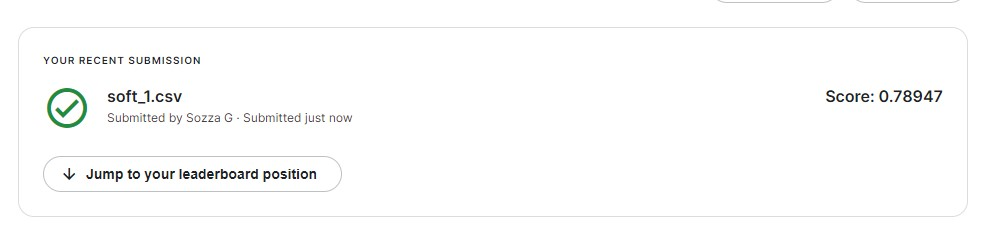

In [ ]:
print('소프트 보팅 정확도 :  0.78947')
Image("soft_1.78947.jpg")

단일모델 lgbm 정확도 :  0.79186


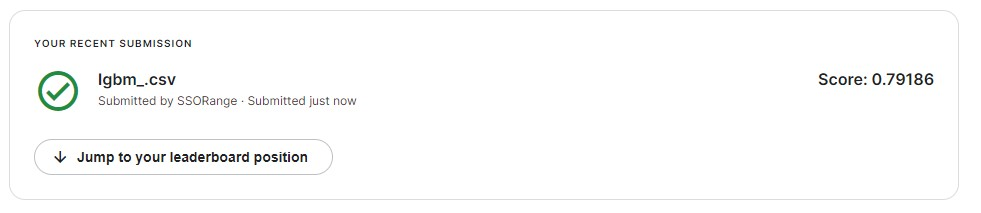

In [ ]:
print('단일모델 lgbm 정확도 :  0.79186')
Image("lgbm_79186.jpg")